In [2]:
import torch
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from tqdm import tqdm
from torch.nn import functional as F
import matplotlib.pyplot as plt

from torch.optim.lr_scheduler import LambdaLR

import os

In [3]:
os.makedirs("checkpoints/", exist_ok=True)

### Load Data

In [4]:
df = pd.read_csv("./Students_Grading_Dataset.csv")

## Manually select Cols (attribute)

In [5]:
unimportant_attribute = ['Student_ID', 'First_Name', 'Last_Name', 'Email', 'Participation_Score']

filtered_df = df.drop(unimportant_attribute, axis=1)
filtered_df

,Gender,Age,Department,Attendance (%),Midterm_Score,Final_Score,Assignments_Avg,Quizzes_Avg,Projects_Score,Total_Score,Grade,Study_Hours_per_Week,Extracurricular_Activities,Internet_Access_at_Home,Parent_Education_Level,Family_Income_Level,Stress_Level (1-10),Sleep_Hours_per_Night
0,Female,22,Engineering,52.29,55.03,57.82,84.22,74.06,85.90,56.09,F,6.2,No,Yes,High School,Medium,5,4.7
1,Male,18,Engineering,97.27,97.23,45.80,NaN,94.24,55.65,50.64,A,19.0,No,Yes,NaN,Medium,4,9.0
2,Male,24,Business,57.19,67.05,93.68,67.70,85.70,73.79,70.30,D,20.7,No,Yes,Master's,Low,6,6.2
3,Female,24,Mathematics,95.15,47.79,80.63,66.06,93.51,92.12,61.63,A,24.8,Yes,Yes,High School,High,3,6.7
4,Female,23,CS,54.18,46.59,78.89,96.85,83.70,68.42,66.13,F,15.4,Yes,Yes,High School,High,2,7.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,Male,19,Business,NaN,82.15,60.33,80.09,99.32,58.42,85.21,D,25.5,No,Yes,High School,Low,10,8.3
4996,Male,19,Business,65.11,86.31,49.80,NaN,88.08,60.87,95.96,C,5.0,No,Yes,NaN,Medium,4,4.0
4997,Female,24,CS,87.54,63.55,64.21,94.28,50.19,82.65,54.25,A,24.8,Yes,No,High School,Medium,4,6.3
4998,Male,23,CS,92.56,79.79,94.28,81.20,61.18,94.29,55.84,A,16.1,Yes,Yes,Bachelor's,Low,1,8.4


In [6]:
category_vars = ['Gender', 'Department', 'Grade', 'Extracurricular_Activities', 'Internet_Access_at_Home', 'Parent_Education_Level', 'Family_Income_Level']
# numerical_score_vars = ['Attendance (%)', 'Midterm_Score', 'Final_Score', 'Assignments_Avg', 'Quizzes_Avg', 'Participation_Score', 'Projects_Score', 'Total_Score', 'Stress_Level (1-10)']
numerical_score_vars = ['Attendance (%)', 'Midterm_Score', 'Final_Score', 'Assignments_Avg', 'Quizzes_Avg', 'Projects_Score', 'Total_Score']
numerical_scalar_vars = list(set(filtered_df.columns) - set(category_vars) - set(numerical_score_vars))
numerical_scalar_vars

['Sleep_Hours_per_Night', 'Study_Hours_per_Week', 'Age', 'Stress_Level (1-10)']

## Separate rows with-Nan and without-Nan

In [7]:
nan_rows = filtered_df.isna().any(axis=1)

# Nan rows
df_nan = filtered_df[nan_rows]
print(f"row with Nan: {df_nan.shape}")

# Complete rows
df_complete = filtered_df[~nan_rows]
print(f"row without Nan: {df_complete.shape}")

row with Nan: (2419, 18)
row without Nan: (2581, 18)


In [8]:
df_train, df_valid, _, _ = train_test_split(df_complete, df_complete, test_size=0.3, random_state=0)

df_train_id = [i for i in range(len(df_train))]
df_valid_id = [i for i in range(len(df_valid))]

print(f"df_train: {df_train.shape}")
print(f"df_valid: {df_valid.shape}")

# print(f"df_train_id: {df_train_id}")
# print(f"df_valid_id: {df_valid_id}")


df_train: (1806, 18)
df_valid: (775, 18)


## Preprocessing: 
1. category to numerical
2. max-min norm

In [9]:
def category_to_numerical(data):
    le = LabelEncoder()
    le.fit(data)
    num_data = le.transform(data)
    
    return num_data, le

def max_min_norm_score(data, train_params = None, process_type = 'train'):
    
    if process_type == 'train':
        data_max = 100
        data_min = 0
    else:
        data_max = 100
        data_min = 0
        
    norm_data = (data - data_min) / (data_max - data_min)    
    
    if process_type == 'train':
        return norm_data, data_max, data_min
    else:
        return norm_data
    
def max_min_norm_scalar(data, train_params = None, process_type = 'train'):
    
    if process_type == 'train':
        data_max = 10
        data_min = 0
    else:
        data_max = 10
        data_min = 0
        
    norm_data = (data - data_min) / (data_max - data_min)    
    
    if process_type == 'train':
        return norm_data, data_max, data_min
    else:
        return norm_data

    
def preprocessing(df, train_params = None, process_type = 'train'):
    
    new_df = pd.DataFrame()
    
    if process_type == 'train':
        train_params = {}
        category_var_len = {}

    # Category 
    for cat_name in category_vars:
        cat_var = df[cat_name]
        if process_type == 'train':
            cat_var, le = category_to_numerical(cat_var)
            train_params[f'{cat_name}_le'] = le
            category_var_len[f'{cat_name}'] = len(np.unique(cat_var))
        else:
            cat_var = train_params[f'{cat_name}_le'].transform(cat_var)
        new_df[f'{cat_name}'] = cat_var
    
    # Numerical score
    for num_name in numerical_score_vars:
        num_var = df[num_name]
        if process_type == 'train':
            num_var, data_max, data_min = max_min_norm_score(num_var, process_type = 'train')
            train_params[num_name] = [data_max, data_min]
        else:
            num_var = max_min_norm_score(num_var, train_params, process_type = 'valid')
        new_df[num_name] = num_var.values
    
    # Numerical scalar
    for num_name in numerical_scalar_vars:
        num_var = df[num_name]
        num_var = np.log(num_var)
        if process_type == 'train':
            num_var, data_max, data_min = max_min_norm_scalar(num_var, process_type = 'train')
            train_params[num_name] = [data_max, data_min]
        else:
            num_var = max_min_norm_scalar(num_var, train_params, process_type = 'valid')
        new_df[num_name] = num_var.values
        
        
    if process_type == 'train':
        return new_df, train_params, category_var_len
    else:
        return new_df


In [10]:
processed_df_train, train_params, category_var_len = preprocessing(df_train, process_type = 'train')
# train_params
print(f"category_var_len: {category_var_len}")
print(f"processed_df_train: {processed_df_train.shape}")

cols_name = processed_df_train.columns
processed_df_train.head()

category_var_len: {'Gender': 2, 'Department': 4, 'Grade': 5, 'Extracurricular_Activities': 2, 'Internet_Access_at_Home': 2, 'Parent_Education_Level': 4, 'Family_Income_Level': 3}
processed_df_train: (1806, 18)


,Gender,Department,Grade,Extracurricular_Activities,Internet_Access_at_Home,Parent_Education_Level,Family_Income_Level,Attendance (%),Midterm_Score,Final_Score,Assignments_Avg,Quizzes_Avg,Projects_Score,Total_Score,Sleep_Hours_per_Night,Study_Hours_per_Week,Age,Stress_Level (1-10)
0,1,1,1,1,1,0,1,0.8989,0.4255,0.5045,0.5528,0.7634,0.5783,0.7426,0.212823,0.332504,0.317805,0.138629
1,1,3,2,0,1,3,2,0.5562,0.8190,0.4543,0.5380,0.9215,0.6371,0.8995,0.193152,0.177495,0.313549,0.069315
2,1,1,4,0,1,1,1,0.6309,0.6057,0.5680,0.5342,0.8288,0.5671,0.5943,0.158924,0.293916,0.294444,0.194591
3,1,2,2,1,1,1,2,0.6077,0.9869,0.4550,0.5771,0.5339,0.5516,0.8337,0.210413,0.282138,0.294444,0.230259
4,0,2,1,0,1,1,2,0.9590,0.8459,0.6858,0.5204,0.6389,0.6554,0.8854,0.218605,0.184055,0.304452,0.179176


In [11]:
processed_df_valid = preprocessing(df_valid, train_params, process_type = 'valid')
print(f"processed_df_valid: {processed_df_valid.shape}")
processed_df_valid.head()

processed_df_valid: (775, 18)


,Gender,Department,Grade,Extracurricular_Activities,Internet_Access_at_Home,Parent_Education_Level,Family_Income_Level,Attendance (%),Midterm_Score,Final_Score,Assignments_Avg,Quizzes_Avg,Projects_Score,Total_Score,Sleep_Hours_per_Night,Study_Hours_per_Week,Age,Stress_Level (1-10)
0,1,3,2,0,1,2,1,0.5154,0.6404,0.5002,0.8728,0.9699,0.8258,0.8888,0.214007,0.283908,0.294444,0.207944
1,1,1,1,1,1,2,1,0.9970,0.9376,0.6142,0.5457,0.7576,0.5397,0.6468,0.141099,0.194591,0.289037,0.207944
2,1,3,2,0,1,3,0,0.6151,0.7315,0.4190,0.5537,0.5564,0.7862,0.5429,0.193152,0.294969,0.317805,0.219722
3,1,1,3,1,1,2,1,0.5228,0.8212,0.9962,0.5518,0.5023,0.8334,0.6564,0.185630,0.319458,0.304452,0.194591
4,1,2,0,0,1,0,2,0.9474,0.5340,0.6216,0.8329,0.7903,0.6250,0.6557,0.200148,0.236085,0.313549,0.109861


In [12]:
BATCH_SIZE = 256
# MASK_RATIO = 30

In [13]:
def masking_helper(data, MASK_RATIO, seed = 42):
    np.random.seed(seed)

    rows, cols = data.shape
    
    # define mask/unmask ratio
    unmask_ratio = ((100 - MASK_RATIO) * cols) // 100
    mask_ratio = cols - unmask_ratio

    # create random index
    # shuff_idx = np.array([np.random.permutation(cols) for _ in range(rows)])
    shuff_idx = np.random.permutation(cols).reshape(1, cols)
    shuff_idx = np.repeat(shuff_idx, rows, axis = 0)

    # define mask/unmask idx
    mask_idx = shuff_idx[:, :mask_ratio]
    unmask_idx = shuff_idx[:, mask_ratio:]
    
    mask_idx.sort(axis=1)
    unmask_idx.sort(axis=1)
    
    # create new_data (contain unmask cols, but remove mask cols)
    new_data = np.zeros((rows, unmask_ratio))
    for i in range(rows):
        new_data[i] = data[i][unmask_idx[i]]
        
    return new_data, unmask_idx, mask_idx, unmask_ratio

def masking_fn(data, mask_ratio, seed):
    sample_size = len(data)

    new_data, unmask_idx, mask_idx, unmask_ratio = masking_helper(data, mask_ratio, seed)
        
    X = [[],[],[],[]]
    Y = []

    for i in range(sample_size):
        X[0].append(new_data[i]) # unmask data
        X[1].append(unmask_idx[i]) # unmask id
        X[2].append(mask_idx[i]) # mask id
        X[3].append(np.ones(unmask_ratio)) # len = unmask, serve as random noisee in VAE
        Y.append(data[i][list(unmask_idx[i])+list(mask_idx[i])]) # label (unmask + mask)

    X[0] = torch.tensor(np.array(X[0])) # unmask data
    X[1] = torch.tensor(np.array(X[1])) # unmask id
    X[2] = torch.tensor(np.array(X[2])) # mask id
    X[3] = torch.tensor(np.array(X[3])) # latent space
    
    Y = torch.tensor(np.array(Y))
    

    return X, Y

In [14]:
def collate_fn_train(data_wtih_type):

    # data
    data = [dat[0] for dat in data_wtih_type]
    data = np.array(data)
    
    # data type: training/valid
    data_type = data_wtih_type[0][1]

    if data_type == 'training':
        seed = np.random.randint(10, size=1)
        mask_ratio = np.random.randint(low = 3, high = 3 + 1, size=1) * 10
        mask_ratio = mask_ratio[0]

    else:
        seed = 42
        mask_ratio = 30
        
    data, label = masking_fn(data, mask_ratio, seed)

    return data, label, mask_ratio

class TableDataset(Dataset):
    def __init__(self, data, data_type = 'training'):
        self.data = data
        self.data_type = data_type
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, id):
        dat = self.data.iloc[id, :]
        dat = np.array(dat)
        return dat, self.data_type
        

        

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


augmented_processed_df_train = [processed_df_train] * 5
augmented_processed_df_train = pd.concat(augmented_processed_df_train, axis = 0)

train_dataset = TableDataset(augmented_processed_df_train)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers = 4, shuffle=False, collate_fn = collate_fn_train)


valid_dataset = TableDataset(processed_df_valid, data_type = 'valid')
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, num_workers = 4, shuffle=False, collate_fn = collate_fn_train)

In [16]:
class Head(nn.Module):
    def __init__(self, num_head, encoder_emb_dim, dropout):
        super().__init__()
        self.num_head = num_head
        self.encoder_emb_dim = encoder_emb_dim

        # up_emb_size * 3 for qkv
        self.qkv_fn = nn.Linear(self.encoder_emb_dim, self.encoder_emb_dim * 3, bias=False)
        self.proj_qkv = nn.Linear(self.encoder_emb_dim, self.encoder_emb_dim, bias = False)
                
        # other
        self.att_dropout = nn.Dropout(dropout)
    
            
    def softclamp(self, t, value = 50.):
        return (t / value).tanh() * value
        
        
    def forward(self, x, iterative):

        batch_size, num_vars, _ = x.shape

        # qkv: up_emb_size * 3
        x = self.qkv_fn(x) 
        q, k, v = x.split(self.encoder_emb_dim, dim = 2) 
        
        # split head: each shape = [batch_size, num_head, num_vars(seq_len), head_size = 8]
        q = q.view(batch_size, num_vars, self.num_head, self.encoder_emb_dim // self.num_head).transpose(1, 2)
        k = k.view(batch_size, num_vars, self.num_head, self.encoder_emb_dim // self.num_head).transpose(1, 2)
        v = v.view(batch_size, num_vars, self.num_head, self.encoder_emb_dim // self.num_head).transpose(1, 2)
        
        # attention matrix calculation: [batch_size, num_head, num_vars(seq_len), num_vars]
        att = (q @ k.transpose(-2,-1)) * (1 / torch.sqrt(torch.ones([1]).to(device) * k.size(-1)))
        
        # masking the att from unmask to mask (Q_unmask to K_mask), 
        # because mask is basically noise, it's meaningless to ask informative vector (Q_unmask) to refer to noise vector (K_mask)
        '''
        it's not causal mask
        it looks like:
                unmask, unmaskm, mask  
        unmask  [1,      1,      0] 
        unmask  [1,      1,      0] 
        mask    [1,      1,      1] 
        '''
        if iterative:
            mask_id = num_vars - 1
            att_mask = torch.ones_like(att)
            att_mask[:, :, :mask_id, -1] = 0
            att = att.masked_fill(att_mask == 0, float('-inf')) 

        # att = self.softclamp(att, 15)

        att = F.softmax(att, dim = -1)
        att = self.att_dropout(att)
        
        # att matrix * V: [batch_size, num_head, num_vars(seq_len), head_size]
        out = att @ v
        out = out.transpose(1,2).contiguous().view(batch_size, num_vars, self.encoder_emb_dim)
        out = self.proj_qkv(out)
        
        return out

class MLP(nn.Module):

    def __init__(self, transformer_emb_size, dropout):
        super().__init__()
        self.up    = nn.Linear(transformer_emb_size, transformer_emb_size * 3)
        self.relu  = nn.ReLU()
        self.down  = nn.Linear(transformer_emb_size * 3, transformer_emb_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.up(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.down(x)
        
        return x
    
class Block(nn.Module):
    def __init__(self, encoder_emb_dim, num_head, dropout):
        super(Block, self).__init__()
        self.ln_head = nn.LayerNorm(encoder_emb_dim)
        self.head = Head(num_head, encoder_emb_dim, dropout)
        self.dropout_head = nn.Dropout(dropout)

        self.ln_mlp = nn.LayerNorm(encoder_emb_dim)
        self.mlp = MLP(encoder_emb_dim, dropout)
        self.dropout_mlp = nn.Dropout(dropout)

    def forward(self, x, iterative):
        
        # att 
        ori_x = x 
        x = self.head(x, iterative)
        x = self.dropout_head(x)
        x = self.ln_head(ori_x + x)
        
        # linear 
        ori_x = x 
        x = self.mlp(x)
        x = self.dropout_mlp(x)
        x = self.ln_mlp(ori_x + x)

        return x

class Transformer(nn.Module):
    def __init__(self, encoder_emb_dim, layers, num_head, dropout):
        super().__init__()
        self.blocks = nn.ModuleList(Block(encoder_emb_dim, num_head, dropout) for _ in range(layers))
        
    def forward(self, x, iterative = False):

        for block in self.blocks:
            x = block(x, iterative)
            
        return x

In [17]:
category_vars = ['Gender', 'Department', 'Grade', 'Extracurricular_Activities', 'Internet_Access_at_Home', 'Parent_Education_Level', 'Family_Income_Level']
numerical_score_vars = ['Attendance (%)', 'Midterm_Score', 'Final_Score', 'Assignments_Avg', 'Quizzes_Avg', 'Projects_Score', 'Total_Score']
numerical_scalar_vars = list(set(filtered_df.columns) - set(category_vars) - set(numerical_score_vars))
numerical_scalar_vars

['Sleep_Hours_per_Night', 'Study_Hours_per_Week', 'Age', 'Stress_Level (1-10)']

In [18]:
class Feature_Embed(nn.Module):
    def __init__(self, cols_name, category_vars, feature_emb_size, num_variables, position_emb_dim, category_var_len):
        super().__init__()
        self.cols_name = cols_name
        self.category_vars = category_vars
        self.feature_emb_size = feature_emb_size
        self.category_var_len = category_var_len
        self.hidden_size = feature_emb_size + position_emb_dim

        # Category feature embedding
        self.cat_encoders = {
            'Gender': nn.Embedding(category_var_len['Gender'] + 1, feature_emb_size),
            'Department': nn.Embedding(category_var_len['Department'] + 1, feature_emb_size),
            'Grade': nn.Embedding(category_var_len['Grade'] + 1, feature_emb_size),
            'Extracurricular_Activities': nn.Embedding(category_var_len['Extracurricular_Activities'] + 1, feature_emb_size),
            'Internet_Access_at_Home': nn.Embedding(category_var_len['Internet_Access_at_Home'] + 1, feature_emb_size),
            'Parent_Education_Level': nn.Embedding(category_var_len['Parent_Education_Level'] + 1, feature_emb_size),
            'Family_Income_Level': nn.Embedding(category_var_len['Family_Income_Level'] + 1, feature_emb_size),
        }
        
        self.cat_decoder1 = nn.Linear(self.hidden_size, self.hidden_size * 2, bias = False)
        self.cat_decoder2 = nn.Linear(self.hidden_size * 2, self.hidden_size * 4, bias = False)
        self.cat_decoder3 = nn.Linear(self.hidden_size * 4, self.hidden_size * 2, bias = False)
        self.cat_decoder4 = nn.Linear(self.hidden_size * 2, self.hidden_size, bias = False)
        self.cat_decoder5 = nn.Linear(self.hidden_size, feature_emb_size, bias = False)
        
        self.cat_decoders = {
        # self.cat_decoders_proj_pred = {
            'Gender': nn.Linear(self.hidden_size, category_var_len['Gender'] + 1, bias=False),
            'Department': nn.Linear(self.hidden_size, category_var_len['Department'] + 1, bias=False),
            'Grade': nn.Linear(self.hidden_size, category_var_len['Grade'] + 1, bias=False),
            'Extracurricular_Activities': nn.Linear(self.hidden_size, category_var_len['Extracurricular_Activities'] + 1, bias=False),
            'Internet_Access_at_Home': nn.Linear(self.hidden_size, category_var_len['Internet_Access_at_Home'] + 1, bias=False),
            'Parent_Education_Level': nn.Linear(self.hidden_size, category_var_len['Parent_Education_Level'] + 1, bias=False),
            'Family_Income_Level': nn.Linear(self.hidden_size, category_var_len['Family_Income_Level'] + 1, bias=False),
        }
        
        # self.cat_encoders['Gender'].weight = self.cat_decoders_proj_pred['Gender'].weight        
        # self.cat_encoders['Department'].weight = self.cat_decoders_proj_pred['Department'].weight        
        # self.cat_encoders['Grade'].weight = self.cat_decoders_proj_pred['Grade'].weight        
        # self.cat_encoders['Extracurricular_Activities'].weight = self.cat_decoders_proj_pred['Extracurricular_Activities'].weight        
        # self.cat_encoders['Internet_Access_at_Home'].weight = self.cat_decoders_proj_pred['Internet_Access_at_Home'].weight        
        # self.cat_encoders['Parent_Education_Level'].weight = self.cat_decoders_proj_pred['Parent_Education_Level'].weight        
        # self.cat_encoders['Family_Income_Level'].weight = self.cat_decoders_proj_pred['Family_Income_Level'].weight        

        # numerical decoder
        self.numerical_decoder1 = nn.Linear(self.hidden_size, self.hidden_size * 2, bias = False)
        self.numerical_decoder2 = nn.Linear(self.hidden_size * 2, self.hidden_size * 4, bias = False)
        self.numerical_decoder3 = nn.Linear(self.hidden_size * 4, self.hidden_size * 2, bias = False)
        self.numerical_decoder4 = nn.Linear(self.hidden_size * 2, self.hidden_size, bias = False)
        self.numerical_decoder5 = nn.Linear(self.hidden_size, 1, bias = False)

        self.relu = nn.ReLU()

        self.cols_id_name = {}
        count = 0
        for col in self.cols_name:
            self.cols_id_name[count] = col
            count += 1
            
        # positional embedding 
        self.position_emb_dim = position_emb_dim
        self.pos_emb = nn.Embedding(num_variables, position_emb_dim)            

    def encode(self, unmasked_data, unmasked_idx, masked_idx):
        
        batch_size, num_unmask_cols = unmasked_data.shape
        _, num_mask_cols = masked_idx.shape
        device = unmasked_data.device
        
        # position info
        unmasked_pos_info = self.pos_emb(unmasked_idx.long()).float()
        masked_pos_info = self.pos_emb(masked_idx.long()).float()        
        
        ''' Feature Encoding for Unmask '''
        
        # iterate every col in unmask
        # for category, do nn.Embedding
        # for numerical, repeat feature_emb_size times
        unmasked_emb = []
        for c in range(num_unmask_cols):
            unmask_attribute_value = unmasked_data[:, c]
            
            # make sure unmask_attribute_id is unique along one col dimension
            # use the unique id to see the choosen attribute is categorial or numerical
            unmask_attribute_id = unmasked_idx[:, c]
            assert len(torch.unique(unmask_attribute_id)) == 1, "unmask_attribute_id in one small batch has to be the same"
            unmask_attribute_id = torch.unique(unmask_attribute_id).item()

            # this col is categorial 
            if self.cols_id_name[unmask_attribute_id] in self.category_vars:
                # print(f"col_name: {self.cols_id_name[unmask_attribute_id]}")
                encoder = self.cat_encoders[self.cols_id_name[unmask_attribute_id]].to(device)
                unmask_attribute_emb = encoder(unmask_attribute_value.long()).float()
                unmasked_emb.append(unmask_attribute_emb)
            # this col is numerical
            else:
                unmask_attribute_value = torch.unsqueeze(unmask_attribute_value, dim = 1)
                unmask_attribute_emb = unmask_attribute_value.repeat(1, self.feature_emb_size)
                unmasked_emb.append(unmask_attribute_emb)

        unmasked_emb = torch.stack(unmasked_emb, dim = 1)
        
        ''' Positional Encoding for Unmask '''
        unmasked_emb = torch.cat([unmasked_emb, unmasked_pos_info], dim = 2) # (batch_size, num_unmask_vars, feature_emb_size + pos_emb_size)

        
        ''' Feature Encoding for Mask '''
        # create noise for categorial and numerical seperately
        masked_emb = []
        for c in range(num_mask_cols):
            mask_attribute_id = masked_idx[:, c]
            assert len(torch.unique(mask_attribute_id)) == 1, "mask_attribute_id in one small batch has to be the same"
            mask_attribute_id = torch.unique(mask_attribute_id).item()

            # this col is categorial 
            if self.cols_id_name[mask_attribute_id] in self.category_vars:
                # get col name
                col_name = self.cols_id_name[mask_attribute_id]
                encoder = self.cat_encoders[col_name].to(device)
                
                # create categorial mask id
                category_mask_id = self.category_var_len[col_name]
                categorial_latent = torch.ones(batch_size).to(device) * category_mask_id

                categorial_emb = encoder(categorial_latent.long()).float()
                masked_emb.append(categorial_emb)
                
            # this col is numerical
            else:
                # create rand(0-1) as numerical latent
                numerical_latent = torch.ones(batch_size).to(device) * torch.rand(1).to(device)
                numerical_latent = torch.unsqueeze(numerical_latent, dim = 1)
                numerical_emb = numerical_latent.repeat(1, self.feature_emb_size)
                masked_emb.append(numerical_emb)

        masked_emb = torch.stack(masked_emb, dim = 1)
        
        ''' Positional Encoding for Mask '''
        masked_emb = torch.cat([masked_emb, masked_pos_info], dim = 2) # (batch_size, num_mask_vars, feature_emb_size + pos_emb_size)

        return unmasked_emb, masked_emb
    
    def decode(self, all_emb, unmask_mask_id):

        batch_size, num_cols, hidden_size = all_emb.shape
        device = all_emb.device
        
        ''' decode for unmask and mask '''
        categorial_preds = []
        numerical_preds = []
        
        categorial_col_name = []
        numerical_col_name = []
        
        for c in range(num_cols):
            # attribute value
            attribute_value = all_emb[:, c, :]

            # attribute id
            attribute_id = unmask_mask_id[:, c]
            assert len(torch.unique(attribute_id)) == 1, "attribute_id in one small batch has to be the same"
            attribute_id = torch.unique(attribute_id).item()

            # this col is categorial 
            if self.cols_id_name[attribute_id] in self.category_vars:
                col_name = self.cols_id_name[attribute_id]
                decoder = self.cat_decoders[col_name].to(device)
                cat_pred = decoder(attribute_value)

                categorial_preds.append(cat_pred)
                categorial_col_name.append(col_name)
                
                # col_name = self.cols_id_name[attribute_id]
                # categorial_preds.append(attribute_value)
                # categorial_col_name.append(col_name)
                
            # this col is numerical
            else:                
                col_name = self.cols_id_name[attribute_id]
                numerical_col_name.append(col_name)
                
                numerical_preds.append(attribute_value)

        # # decode for categorial
        # categorial_preds = torch.stack(categorial_preds, dim = 1)
        
        # ori_categorial_preds = categorial_preds
        
        # categorial_preds = self.cat_decoder1(categorial_preds).to(device)
        # categorial_preds = self.relu(categorial_preds)
        
        # categorial_preds = self.cat_decoder2(categorial_preds).to(device)
        # categorial_preds = self.relu(categorial_preds)
        
        # categorial_preds = self.cat_decoder3(categorial_preds).to(device)
        # categorial_preds = self.relu(categorial_preds)
        
        # categorial_preds = self.cat_decoder4(categorial_preds).to(device)
        # categorial_preds = self.relu(categorial_preds)
        
        # # residual connection
        # categorial_preds = categorial_preds + ori_categorial_preds
        # categorial_preds = self.cat_decoder5(categorial_preds).to(device)

        # categorial_projs = []
        # for i in range(len(self.category_vars)):
        #     decoder = self.cat_decoders_proj_pred[categorial_col_name[i]].to(device)
        #     pred = decoder(categorial_preds[:, i, :])
        #     categorial_projs.append(pred)
        # categorial_preds = categorial_projs

        # decode for numerical
        numerical_preds = torch.stack(numerical_preds, dim = 1)
        
        ori_numerical_preds = numerical_preds
        
        numerical_preds = self.numerical_decoder1(numerical_preds).to(device)
        numerical_preds = self.relu(numerical_preds)
        
        numerical_preds = self.numerical_decoder2(numerical_preds).to(device)
        numerical_preds = self.relu(numerical_preds)
        
        numerical_preds = self.numerical_decoder3(numerical_preds).to(device)
        numerical_preds = self.relu(numerical_preds)
        
        numerical_preds = self.numerical_decoder4(numerical_preds).to(device)
        numerical_preds = self.relu(numerical_preds)
        
        # residual connection
        numerical_preds = numerical_preds + ori_numerical_preds
        numerical_preds = self.numerical_decoder5(numerical_preds).to(device)

        numerical_preds = torch.squeeze(numerical_preds)
        
        return categorial_preds, numerical_preds, categorial_col_name, numerical_col_name
    
    
    def reorder_label_fn(self, label, unmask_mask_id):
        
        batch_size, num_cols = label.shape
        device = label.device
        
        ''' reorder for unmask and mask '''
        categorial_labels = []
        numerical_labels = []
        
        for c in range(num_cols):
            # attribute value
            attribute_value = label[:, c]

            # attribute id
            attribute_id = unmask_mask_id[:, c]
            assert len(torch.unique(attribute_id)) == 1, "attribute_id in one small batch has to be the same"
            attribute_id = torch.unique(attribute_id).item()

            # this col is categorial 
            if self.cols_id_name[attribute_id] in self.category_vars:
                categorial_labels.append(attribute_value)
                
            # this col is numerical
            else:
                numerical_labels.append(attribute_value)
              
        numerical_labels = torch.stack(numerical_labels, dim = 1)

        return categorial_labels, numerical_labels
    

In [19]:
class tableMET(nn.Module):
    def __init__(self, position_emb_dim, layers_encode, layers_decode, layers_iterative_transformer, \
                 num_head, num_variables, cols_name, category_vars, feature_emb_size, category_var_len, dropout):
        super().__init__()
        self.num_variables = num_variables

        # feature embedding
        self.feature_emb_fn = Feature_Embed(cols_name, category_vars, feature_emb_size, num_variables, position_emb_dim, category_var_len)

        # encoder and decoder
        self.transformer_encode = Transformer(position_emb_dim + feature_emb_size, layers_encode, num_head, dropout)
        self.transformer_decode = Transformer(position_emb_dim + feature_emb_size, layers_decode, num_head, dropout)
        
        # iterative transformer decoding
        # self.iterative_transformer_decode = nn.ModuleList(Transformer(position_emb_dim + feature_emb_size, layers_iterative_transformer, num_head, dropout) for _ in range(self.mask_ratio))
        self.iterative_transformer_decode = Transformer(position_emb_dim + feature_emb_size, layers_iterative_transformer, num_head, dropout)
        
    def forward(self, unmasked_data, unmasked_idx, masked_idx, label, mask_ratio):
        self.unmask_ratio = ((100 - mask_ratio) * self.num_variables) // 100
        self.mask_ratio = self.num_variables - ((100 - mask_ratio) * self.num_variables) // 100
    
        ''' feature & position encoding for Unmask and Mask '''
        # unmask_emb: [batch_size, num_unmask = 12, hidden_size(position_emb_dim + feature_emb_size)]: ([4, 12, 64])
        # mask_emb: [batch_size, num_mask = 6, hidden_size(position_emb_dim + feature_emb_size)]: ([4, 6, 64])
        unmask_emb, mask_emb = self.feature_emb_fn.encode(unmasked_data, unmasked_idx, masked_idx)
        
        # transformer (encoder) only for unmasked part
        # unmask_emb: [batch_size, num_unmask = 12, hidden_size(position_emb_dim + feature_emb_size)]: ([4, 12, 64])
        ori_unmask_emb = unmask_emb
        unmask_emb = self.transformer_encode(unmask_emb)
        unmask_emb = unmask_emb + ori_unmask_emb
        
        # iterative transformer decoding
        mask_emb_iter = []
        for mask_id in range(self.mask_ratio):
            maske_e = torch.unsqueeze(mask_emb[:, mask_id, :], dim = 1)
            unmask_mask_emb = torch.cat([unmask_emb, maske_e], dim = 1)
            unmask_mask_emb = self.iterative_transformer_decode(unmask_mask_emb, iterative = True)
            mask_emb_ = torch.unsqueeze(unmask_mask_emb[:, -1, :], dim = 1)
            mask_emb_iter.append(mask_emb_)

        mask_emb_iter = torch.cat(mask_emb_iter, dim = 1)
    
        # concat unmask_emb and mask_emb
        all_emb = torch.cat([unmask_emb, mask_emb_iter], dim = 1)
        
        # transformer (decoder) for both unmasked and masked
        # all_emb: [batch_size, num_vars = 18, hidden_size(position_emb_dim + feature_emb_size)]: ([4, 18, 64])
        ori_all_emb = all_emb
        all_emb = self.transformer_decode(all_emb)
        all_emb = all_emb + ori_all_emb
        
        ''' feature & position decoding for Unmask and Mask '''
        unmask_mask_id = torch.cat([unmasked_idx, masked_idx], dim = 1)
        categorial_preds, numerical_preds, categorial_col_name, numerical_col_name = self.feature_emb_fn.decode(all_emb, unmask_mask_id)

        ''' reorder label: make label' variable order align as pred '''
        categorial_labels, numerical_labels = self.feature_emb_fn.reorder_label_fn(label, unmask_mask_id)
            

        return categorial_preds, numerical_preds, categorial_labels, numerical_labels, categorial_col_name, numerical_col_name
    
        

In [20]:
def linear_warmup_decay_lr(lr_init, lr_final, num_warmup_steps, num_training_steps):
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return current_step / num_warmup_steps 
        else:
            progress = (current_step - num_warmup_steps) / (num_training_steps - num_warmup_steps)
            return (1 - progress) * (1 - lr_final / lr_init) + (lr_final / lr_init)  
    return lr_lambda

In [21]:
LEARNING_RATE = 2e-4
EPOCHS = 1 
layers_encode = 6
layers_decode = 1
layers_iterative_transformer = 2
num_head = 1
dropout = 0.4
num_variables = 18
cols_name = processed_df_train.columns
position_emb_dim = 16
feature_emb_size = 16
category_var_len = category_var_len

is_power_of_two = lambda n: n > 0 and (n & (n - 1)) == 0
assert is_power_of_two(position_emb_dim + feature_emb_size), "position_emb_dim + feature_emb_size should be power term of 2"

model = tableMET(position_emb_dim, layers_encode, layers_decode, layers_iterative_transformer,\
                num_head, num_variables, cols_name, category_vars, feature_emb_size, category_var_len, dropout).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.95), eps=1e-6, weight_decay=1e-3)

scheduler = LambdaLR(optimizer, lr_lambda=linear_warmup_decay_lr(lr_init = LEARNING_RATE, lr_final = LEARNING_RATE * 1e-2, num_warmup_steps = 10, num_training_steps = EPOCHS))


In [22]:
MSE_loss_fn = nn.MSELoss()
CE_loss_fn = nn.CrossEntropyLoss()

def loss_fn(categorial_pred, numerical_pred, categorial_label, numerical_label):
    
    num_numerical = 12
    num_category = 7
    ratio_numerical = num_numerical / (num_numerical + num_category)
    ratio_category = 1 / (num_numerical + num_category)
    
    total_loss = torch.zeros(1).to(device)
    
    mse_loss = MSE_loss_fn(numerical_pred, numerical_label)
    mse_loss = mse_loss * 1 
    total_loss += (mse_loss * ratio_numerical)
    
    for i in range(num_category):
        pred = categorial_pred[i]
        label = categorial_label[i]        
        loss = CE_loss_fn(pred, label.long())
        total_loss += (loss * ratio_category)
        
    return total_loss, mse_loss, (total_loss - mse_loss).item()

In [23]:
train_LOSS = []
valid_LOSS = []

for epoch in tqdm(range(EPOCHS), desc="iterate epoch"):
    
    losses = []
    mse_losses = []
    ce_losses = []
    
    val_losses = []
    val_mse_losses = []
    val_ce_losses = []

    model.train()
    for data, label, mask_ratio in train_dataloader:
        unmask_ratio = ((100 - mask_ratio) * num_variables) // 100
        
        unmasked_data = data[0].float().to(device)
        unmasked_idx = data[1].long().to(device)
        masked_idx = data[2].long().to(device)
        latent = data[3].float().to(device)
        label = label.float().to(device)
        
        categorial_pred, numerical_pred, categorial_label, numerical_label, categorial_col_name,\
            numerical_col_name = model(unmasked_data, unmasked_idx, masked_idx, label, mask_ratio)
        
        loss, mse_loss, ce_loss = loss_fn(categorial_pred, numerical_pred, categorial_label, numerical_label)
        
        losses.append(loss.item())
        mse_losses.append(mse_loss.item())
        ce_losses.append(ce_loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    scheduler.step()
    
    losses = np.mean(losses)
    mse_losses = np.mean(mse_losses)
    ce_losses = np.mean(ce_losses)
    train_LOSS.append(losses)
    
    if epoch % 50 == 0:
        print(f'TRAINING, total variables are {num_variables}: first {unmask_ratio} unmasked, latter {num_variables - unmask_ratio}')
        print(f"epoch: {epoch}, loss: {losses}, mse: {mse_losses}, ce: {ce_losses}")
    
    with torch.no_grad():
        model.eval()
        for data, label, mask_ratio in valid_dataloader:
            unmask_ratio = ((100 - mask_ratio) * num_variables) // 100            
            
            unmasked_data = data[0].float().to(device)
            unmasked_idx = data[1].long().to(device)
            masked_idx = data[2].long().to(device)
            latent = data[3].float().to(device)
            label = label.float().to(device)

            categorial_pred, numerical_pred, categorial_label, numerical_label, categorial_col_name,\
                numerical_col_name = model(unmasked_data, unmasked_idx, masked_idx, label, mask_ratio)
            
            loss, mse_loss, ce_loss = loss_fn(categorial_pred, numerical_pred, categorial_label, numerical_label)

            val_losses.append(loss.item())
            val_mse_losses.append(mse_loss.item())
            val_ce_losses.append(ce_loss)            
            
    val_losses = np.mean(val_losses)
    val_mse_losses = np.mean(val_mse_losses)
    val_ce_losses = np.mean(val_ce_losses)
    valid_LOSS.append(val_losses)
    
    if epoch % 50 == 0:
        print(f'VALID, total variables are {num_variables}: first {unmask_ratio} unmasked, latter {num_variables - unmask_ratio}')
        print(f"epoch: {epoch}, val_loss: {val_losses}, val_mse: {val_mse_losses}, val_ce_losses: {val_ce_losses}")
        print()      

model.save_pretrained("checkpoints/FT_MET")
  
        
    

iterate epoch:   0%|          | 0/1 [00:00<?, ?it/s]

TRAINING, total variables are 18: first 12 unmasked, latter 6
epoch: 0, loss: 2.219996598031786, mse: 2.319740596744749, ce: -0.09974399871296352


iterate epoch: 100%|██████████| 1/1 [00:08<00:00,  8.65s/it]

VALID, total variables are 18: first 12 unmasked, latter 6
epoch: 0, val_loss: 2.872875928878784, val_mse: 3.2918390035629272, val_ce_losses: -0.41896307468414307



AttributeError: 'tableMET' object has no attribute 'save_pretrained'

/tmp/ipykernel_677224/2125145983.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


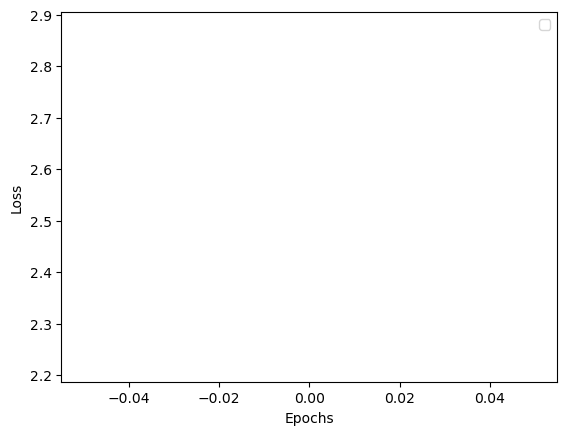

In [24]:
plt.plot(range(len(train_LOSS)), train_LOSS, color = 'blue')
plt.plot(range(len(valid_LOSS)), valid_LOSS, color = 'red')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Inference

In [25]:
def reverse_norm(df):
    
    new_df = pd.DataFrame()
    

    # Category 
    for cat_name in category_vars:
        cat_var = df[cat_name]
        new_df[f'{cat_name}'] = cat_var
    
    # Numerical score
    for num_name in numerical_score_vars:
        num_var = df[num_name]
        
        # reverse (0 - 100) min max norm
        num_var = (num_var * 100) + 0
        
        new_df[num_name] = num_var.values
    
    # Numerical scalar
    for num_name in numerical_scalar_vars:
        num_var = df[num_name]
        
        # reverse (0 - 10) min max norm
        num_var = (num_var * 10) + 0
        # reverse
        num_var = np.exp(num_var)
        new_df[num_name] = num_var.values
        
    return new_df

In [26]:
select_sample_id = 0


In [ ]:
unmasked_idx_one = np.array(unmasked_idx[select_sample_id].detach().cpu(), dtype=int)
masked_idx_one = np.array(masked_idx[select_sample_id].detach().cpu(), dtype=int)


categorial_pred_one = []
for pred in categorial_pred:
    argmax_pred = torch.argmax(pred, dim = 1)
    categorial_pred_one.append(argmax_pred)
categorial_pred_one = torch.stack(categorial_pred_one, dim = 1)
categorial_pred_one = np.array(categorial_pred_one[select_sample_id].detach().cpu())

categorial_label_one = torch.stack(categorial_label, dim = 1)
categorial_label_one = np.array(categorial_label_one[select_sample_id].detach().cpu())

numerical_pred_one = np.array(numerical_pred[select_sample_id].detach().cpu())
numerical_label_one = np.array(numerical_label[select_sample_id].detach().cpu())


print(f"categorial_pred_one: {categorial_pred_one.shape}")
print(f"categorial_label_one: {categorial_label_one.shape}")
print(f"numerical_pred_one: {numerical_pred_one.shape}")
print(f"numerical_label_one: {numerical_label_one.shape}")

categorial_pred_one: (7,)
categorial_label_one: (7,)
numerical_pred_one: (11,)
numerical_label_one: (11,)


In [32]:
categorial_col_name

['Grade',
 'Internet_Access_at_Home',
 'Family_Income_Level',
 'Gender',
 'Department',
 'Extracurricular_Activities',
 'Parent_Education_Level']

In [34]:
pred = np.concat([categorial_pred_one, numerical_pred_one], axis = 0)
label = np.concat([categorial_label_one, numerical_label_one], axis = 0)

print(f"pred: {pred.shape}")
print(f"label: {label.shape}")

res = pd.DataFrame([pred, label], columns = categorial_col_name + numerical_col_name)
reverse_res = reverse_norm(res)

pred: (18,)
label: (18,)


In [29]:
reverse_res[cols_name[masked_idx_one]]

,Gender,Department,Extracurricular_Activities,Parent_Education_Level,Midterm_Score,Total_Score
0,0.0,4.0,2.0,3.0,-43.065909,-13.123268
1,0.0,1.0,1.0,0.0,45.100001,50.220001


In [30]:
reverse_res[cols_name[unmasked_idx_one]]

,Grade,Internet_Access_at_Home,Family_Income_Level,Attendance (%),Final_Score,Assignments_Avg,Quizzes_Avg,Projects_Score,Sleep_Hours_per_Night,Study_Hours_per_Week,Age,Stress_Level (1-10)
0,2.0,2.0,1.0,-39.918190,-130.266321,-258.843493,-141.264093,-25.150052,1847.221695,6.233822e-07,3.754792e-09,6.893634e-09
1,2.0,1.0,2.0,80.299997,76.289999,83.420002,65.230000,93.500000,7.400000,2.110000e+01,2.400000e+01,5.000000e+00


In [31]:
category_vars = ['Gender', 'Department', 'Grade', 'Extracurricular_Activities', 'Internet_Access_at_Home', 'Parent_Education_Level', 'Family_Income_Level']
numerical_score_vars = ['Attendance (%)', 'Midterm_Score', 'Final_Score', 'Assignments_Avg', 'Quizzes_Avg', 'Projects_Score', 'Total_Score']
numerical_scalar_vars = list(set(filtered_df.columns) - set(category_vars) - set(numerical_score_vars))
numerical_scalar_vars
# ['Study_Hours_per_Week', 'Age', 'Stress_Level (1-10)', 'Sleep_Hours_per_Night']


['Sleep_Hours_per_Night', 'Study_Hours_per_Week', 'Age', 'Stress_Level (1-10)']